In [1]:
%matplotlib inline
import torch
from sebm.models import Encoder, Decoder
from torchvision import datasets, transforms
from sebm.data import load_data

dataset =  'mnist' # 'svhn' # 'cifar10' # 'mnist' #  'flowers102' #
if dataset == 'mnist':
    input_channels, im_height, im_width = 1, 28, 28
else:
    input_channels, im_height, im_width = 3, 32, 32
device = torch.device('cuda:1')
arch =  'simplenet2' # 'wresnet' # 'simplenet'
lr = 1e-4
seed = 1
latent_dim = 128
activation = 'ReLU'
reparameterized = True
load_version = 'vae-d=%s-seed=%s-lr=%s-zd=%s-act=%s-arch=%s' % (dataset, seed, lr, latent_dim, activation, arch)
data_dir = '/home/hao/Research/sebm_data/'
batch_size = 100
test_data, _ = load_data(dataset, data_dir, batch_size, train=False, normalize=False)
if arch == 'simplenet2':
    enc = Encoder(arch=arch,
                  reparameterized=reparameterized,
                  im_height=im_height, 
                  im_width=im_width, 
                  input_channels=input_channels, 
                  channels=[64,64,32,32], 
                  kernels=[3,4,4,4], 
                  strides=[1,2,2,2], 
                  paddings=[1,1,1,1], 
                  hidden_dim=[128],
                  latent_dim=latent_dim,
                  activation=activation)
    dec = Decoder(arch=arch,
                  device=device,
                  input_channels=input_channels, 
                  channels=[64,64,32,32], 
                  kernels=[3,4,4,4], 
                  strides=[1,2,2,2], 
                  paddings=[1,1,1,1], 
                  output_paddings=[1,0,0,0], ## TODO: hand-coded for now
                  hidden_dim=[128],
                  latent_dim=latent_dim,
                  output_dim=288, ## TODO: hand-coded for now
                  activation=activation)
else:
    raise NotImplementError
enc.cuda().to(device)  
dec.cuda().to(device)
print('Loading trained models...')
enc.load_state_dict(torch.load('../weights/cp-%s' % load_version)['enc_state_dict'])
dec.load_state_dict(torch.load('../weights/cp-%s' % load_version)['dec_state_dict'])

Note: downsampling function is Resize(size=1, interpolation=PIL.Image.BILINEAR)
Loading trained models...


<All keys matched successfully>

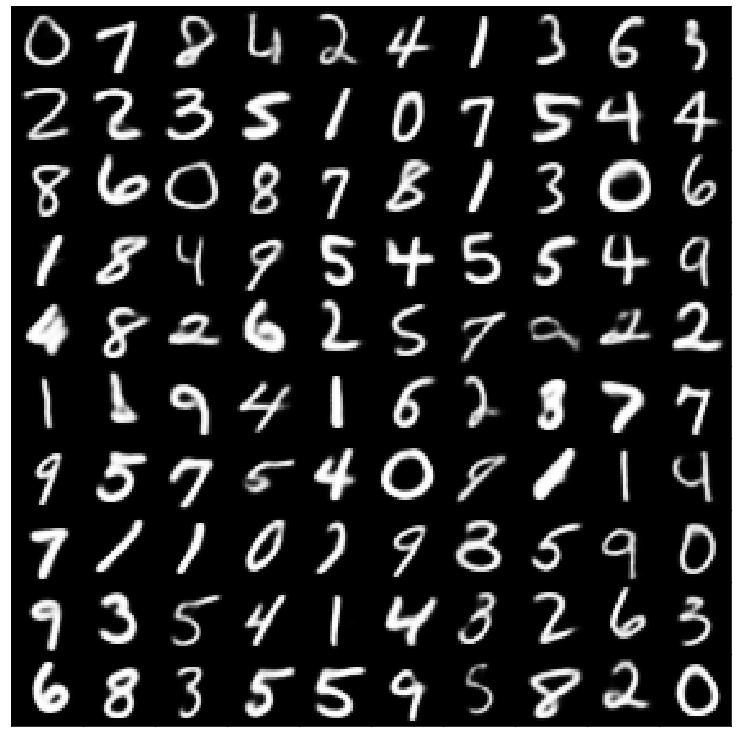

In [2]:
from sebm.eval import plot_samples, compress_tsne_vae, plot_tsne

for (images, _) in test_data:
    break
images = images.cuda().to(device)
latents, q_log_prob = enc.forward(images)
recons, ll, p_log_prob = dec.forward(latents, images)
# images = images.squeeze().view(batch_size, 784).repeat(sample_size, 1, 1).cuda().to(device)
# latents, _ = enc.forward(images)
# _, recons, _ = dec.forward(latents, images)
plot_samples(recons.view(batch_size, 28, 28))

In [ ]:
zs2, ys = compress_tsne_vae(data, enc, device)


In [ ]:
plot_tsne(num_classes=10, zs2, ys)